In [89]:
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from fake_useragent import UserAgent
import googlemaps
import json
from haversine import haversine, Unit

# 1. 스타벅스 매장 정보 스크래핑

## 1-1. 스타벅스 사이트 분석

In [8]:
starbucks_url = 'https://www.starbucks.co.kr/index.do'
driver = webdriver.Chrome('./driver/chromedriver.exe')
driver.get(starbucks_url)

In [9]:
driver.maximize_window()

In [10]:
# 매장 찾기 -> 지역검색 화면으로 진입
action = ActionChains(driver)
first_tag = driver.find_element(By.CSS_SELECTOR, '#gnb > div > nav > div > ul > li.gnb_nav03')
second_tag = driver.find_element(By.CSS_SELECTOR, '#gnb > div > nav > div > ul > li.gnb_nav03 > div > div > div > ul:nth-child(1) > li:nth-child(3) > a')
action.move_to_element(first_tag).move_to_element(second_tag).click().perform()

In [12]:
# 시/도 선택화면에서 '서울' 선택
seoul_tag = driver.find_element(By.CSS_SELECTOR, '#container > div > form > fieldset > div > section > article.find_store_cont > article > article:nth-child(4) > div.loca_step1 > div.loca_step1_cont > ul > li:nth-child(1) > a')
seoul_tag.click()

In [13]:
# 서울시 구 리스트 확보
seoul_gu_list = driver.find_element(By.CLASS_NAME, 'gugun_arae_box').find_elements(By.TAG_NAME, 'li')
len(seoul_gu_list)

26

In [14]:
seoul_gu_list = seoul_gu_list[1:]
len(seoul_gu_list)

25

In [15]:
# 강남구 선택
seoul_gu_list[0].click()

In [16]:
# BeautifulSoup을 이용한 html 정보 수집
req = driver.page_source
soup = BeautifulSoup(req, 'html.parser')
stores = soup.find('ul', 'quickSearchResultBoxSidoGugun').find_all('li')
len(stores)

89

In [17]:
# 반복문을 이용한 매장 정보 수집
for store in stores:
    store_name = store.find('strong').text
    store_addr = store.find('p').text
    store_lat = store['data-lat']
    store_lng = store['data-long']
    print(store_name)
    print(store_addr)
    print(store_lat)
    print(store_lng)
    print('+'*35)

역삼이마트  
서울특별시 강남구 역삼로 310 (역삼동)1522-3232
37.499367
127.048425
+++++++++++++++++++++++++++++++++++
청담역  
서울특별시 강남구 삼성로 709 (청담동)1522-3232
37.5194407323478
127.049552661542
+++++++++++++++++++++++++++++++++++
삼성동  
서울특별시 강남구 영동대로96길 12 (삼성동)1522-3232
37.510843366121534
127.06363342044263
+++++++++++++++++++++++++++++++++++
강남논현  
서울특별시 강남구 강남대로 512 (논현동)1522-3232
37.5078978596254
127.023338614644
+++++++++++++++++++++++++++++++++++
테헤란로아남타워  
서울특별시 강남구 테헤란로 311 (역삼동)1522-3232
37.50383
127.04487
+++++++++++++++++++++++++++++++++++
삼성역  
서울특별시 강남구 테헤란로 620 (대치동)1522-3232
37.509206962541256
127.06560851480327
+++++++++++++++++++++++++++++++++++
강남역신분당역사  
서울특별시 강남구 강남대로 396 (역삼동)1522-3232
37.4970572543978
127.028180714381
+++++++++++++++++++++++++++++++++++
언주역  
서울특별시 강남구 봉은사로 222 (역삼동)1522-3232
37.507775
127.036472
+++++++++++++++++++++++++++++++++++
대치삼성프라자  
서울특별시 강남구 영동대로 237 (대치동)1522-3232
37.500313
127.066961
+++++++++++++++++++++++++++++++++++
강남세곡  
서울특별시 강남구 헌릉로569길 18 (세곡동)1522-3

In [18]:
# '지역검색' 화면으로 복귀
back_to_select = driver.find_element(By.CSS_SELECTOR, '#container > div > form > fieldset > div > section > article.find_store_cont > article > header.loca_search > h3')
back_to_select.click()

In [19]:
driver.quit()

## 1-2. 스타벅스 매장 정보 스크랩 - 함수

In [41]:
def fetch_starbucks():
    starbucks_url = 'https://www.starbucks.co.kr/index.do'
    
    ua = UserAgent()
    user_agent = ua.chrome
    options = webdriver.ChromeOptions()
    options.add_argument(f'user-agent={user_agent}')
    
    driver = webdriver.Chrome('./driver/chromedriver.exe', options=options)
    driver.get(starbucks_url)
    driver.maximize_window()

    # 매장찾기 -> 지역검색
    time.sleep(1)
    action = ActionChains(driver)
    first_tag = driver.find_element(By.CSS_SELECTOR, '#gnb > div > nav > div > ul > li.gnb_nav03')
    second_tag = driver.find_element(By.CSS_SELECTOR, '#gnb > div > nav > div > ul > li.gnb_nav03 > div > div > div > ul:nth-child(1) > li:nth-child(3) > a')
    action.move_to_element(first_tag).move_to_element(second_tag).click().perform()

    # 시도선택 - 서울
    seoul_tag = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.CSS_SELECTOR, '#container > div > form > fieldset > div > section > article.find_store_cont > article > article:nth-child(4) > div.loca_step1 > div.loca_step1_cont > ul > li:nth-child(1) > a')))
    seoul_tag.click()

    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'set_gugun_cd_btn')))

    # 매장정보를 담기 위한 빈 리스트
    store_list = []
    addr_list = []
    lat_list = []
    lng_list = []
    
    # 서울시 - 전체 선택
    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'set_gugun_cd_btn')))
    gu_elements = driver.find_elements(By.CLASS_NAME, 'set_gugun_cd_btn')
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, f'#mCSB_2_container > ul > li:nth-child(1) > a')))    
    gu_elements[0].click()
    
    # 매장정보가 뜨기까지 대기
    WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'quickResultLstCon')))
    
    # 뷰티풀숲을 이용해 스크래핑 하기
    req = driver.page_source
    soup = BeautifulSoup(req, 'html.parser')
    stores = soup.find('ul', 'quickSearchResultBoxSidoGugun').find_all('li')
    
    # 매장이름, 주소, 위도, 경도
    for store in stores:
        store_name = store.find('strong').text
        store_addr = store.find('p').text
        store_lat = store['data-lat']
        store_lng = store['data-long']
        store_list.append(store_name)
        addr_list.append(store_addr)
        lat_list.append(store_lat)
        lng_list.append(store_lng)
        
    # 수집한 정보를 데이터 프레임으로 변환
    df = pd.DataFrame({
        'store': store_list,
        'addr': addr_list,
        'lat': lat_list,
        'lng': lng_list,
    })

    driver.quit()
    
    return df

In [42]:
starbucks = fetch_starbucks()
starbucks

,store,addr,lat,lng
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동)1522-3232,37.501087,127.043069
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동)1522-3232,37.510178,127.022223
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동)1522-3232,37.5139309,127.0206057
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동)1522-3232,37.499517,127.031495
4,대치재경빌딩R,서울특별시 강남구 남부순환로 2947 (대치동)1522-3232,37.494668,127.062583
...,...,...,...,...
602,사가정역,서울특별시 중랑구 면목로 3101522-3232,37.579594,127.087966
603,상봉역,서울특별시 중랑구 망우로 307 (상봉동)1522-3232,37.59689,127.08647
604,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층1522-3232",37.615368,127.076633
605,양원역,서울특별시 중랑구 양원역로10길 3 (망우동)1522-3232,37.6066536267232,127.106359790053


## 1-3. 스크래핑 결과 확인

In [43]:
gu_name = starbucks['addr'].str.split().str[1]
len(gu_name.unique()), gu_name.unique()

(25,
 array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
        '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
        '중구', '강동구', '구로구', '동대문구', '성동구', '용산구', '중랑구'], dtype=object))

In [44]:
starbucks['구'] = starbucks['addr'].str.split().str[1]
starbucks

,store,addr,lat,lng,구
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동)1522-3232,37.501087,127.043069,강남구
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동)1522-3232,37.510178,127.022223,강남구
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동)1522-3232,37.5139309,127.0206057,강남구
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동)1522-3232,37.499517,127.031495,강남구
4,대치재경빌딩R,서울특별시 강남구 남부순환로 2947 (대치동)1522-3232,37.494668,127.062583,강남구
...,...,...,...,...,...
602,사가정역,서울특별시 중랑구 면목로 3101522-3232,37.579594,127.087966,중랑구
603,상봉역,서울특별시 중랑구 망우로 307 (상봉동)1522-3232,37.59689,127.08647,중랑구
604,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층1522-3232",37.615368,127.076633,중랑구
605,양원역,서울특별시 중랑구 양원역로10길 3 (망우동)1522-3232,37.6066536267232,127.106359790053,중랑구


In [45]:
starbucks['addr'] = starbucks['addr'].str.replace('1522-3232', '')
starbucks

,store,addr,lat,lng,구
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,강남구
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,강남구
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),37.5139309,127.0206057,강남구
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,강남구
4,대치재경빌딩R,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,강남구
...,...,...,...,...,...
602,사가정역,서울특별시 중랑구 면목로 310,37.579594,127.087966,중랑구
603,상봉역,서울특별시 중랑구 망우로 307 (상봉동),37.59689,127.08647,중랑구
604,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,중랑구
605,양원역,서울특별시 중랑구 양원역로10길 3 (망우동),37.6066536267232,127.106359790053,중랑구


In [50]:
starbucks = starbucks[['store', '구', 'addr', 'lat', 'lng']]
starbucks

,store,구,addr,lat,lng
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.5139309,127.0206057
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583
...,...,...,...,...,...
602,사가정역,중랑구,서울특별시 중랑구 면목로 310,37.579594,127.087966
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.59689,127.08647
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.6066536267232,127.106359790053


## 1-4. 스타벅스 매장 정보 -> 파일로 저장

In [51]:
starbucks.to_csv('./data/starbucks_info.csv', sep=',', encoding='utf-8', index=0)

In [52]:
df = pd.read_csv('./data/starbucks_info.csv', encoding='utf-8')

In [53]:
df

,store,구,addr,lat,lng
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583
...,...,...,...,...,...
602,사가정역,중랑구,서울특별시 중랑구 면목로 310,37.579594,127.087966
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   store   607 non-null    object 
 1   구       607 non-null    object 
 2   addr    607 non-null    object 
 3   lat     607 non-null    float64
 4   lng     607 non-null    float64
dtypes: float64(2), object(3)
memory usage: 23.8+ KB


In [56]:
gu_list = df['구'].unique()
gu_list, len(gu_list)

(array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
        '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
        '중구', '강동구', '구로구', '동대문구', '성동구', '용산구', '중랑구'], dtype=object),
 25)

# 2. 이디야 매장 정보 스크래핑

## 2-1. 이디야 사이트 분석

In [37]:
ediya_url = 'https://ediya.com/'
driver = webdriver.Chrome('./driver/chromedriver.exe')
driver.get(ediya_url)

In [38]:
driver.maximize_window()

In [57]:
# 매장찾기 클릭
driver.find_element(By.CSS_SELECTOR, 'body > header > div > div > div.gnb_wrap > div.top_util > ul.top_members > li.store > a').click()

In [58]:
# 주소 탭 클릭
driver.find_element(By.CSS_SELECTOR, '#contentWrap > div.contents > div > div.store_search_pop > ul > li:nth-child(2) > a').click()

In [59]:
# 주소 입력창 선택
driver.find_element(By.CSS_SELECTOR, '#keyword').click()

In [60]:
# 주소 입력
driver.find_element(By.CSS_SELECTOR, '#keyword').send_keys('강남구')

In [61]:
# 검색버튼 클릭
driver.find_element(By.CSS_SELECTOR, '#keyword_div > form > button').click()

In [62]:
# 뷰티풀 숲 활용
tmp = driver.page_source
soup = BeautifulSoup(tmp, 'html.parser')
store_list = soup.find(id='placesList').find_all('li')

In [128]:
for store in store_list:
    store_name = store.find('dl').find('dt').text
    addr = store.find('dl').find('dd').text
    map_raw = store.find('a').get('onclick')
    
    print('매장명 : ', store_name)    
    print('주소 : ', addr)
    
    pattern = re.compile(r"panLatTo\((.+?),(.+?),(.+?)\)")
    if pattern.match(map_raw):
        lng = pattern.match(map_raw).group(1)
        lat = pattern.match(map_raw).group(2)
        
        lng = lng.split("'")[1]
        lng = float(lng)
        
        lat = lat.split("'")[1]
        lat = float(lat)
        
        print('위도 : ', lat)
        print('경도 : ', lng)
    print('+'*35)

매장명 :  강남YMCA점
주소 :  서울 강남구 논현동
위도 :  0.0
경도 :  0.0
+++++++++++++++++++++++++++++++++++
매장명 :  강남구청역아이티웨딩점
주소 :  서울 강남구 학동로 338 (논현동, 강남파라곤)
위도 :  37.51654171724045
경도 :  127.0401601992311
+++++++++++++++++++++++++++++++++++
매장명 :  강남논현학동점
주소 :  서울 강남구 논현로131길 28 (논현동)
위도 :  37.51408005446769
경도 :  127.02810578707653
+++++++++++++++++++++++++++++++++++
매장명 :  강남대치점
주소 :  서울 강남구 역삼로 415 (대치동, 성진빌딩)
위도 :  37.50133876179308
경도 :  127.05242928262568
+++++++++++++++++++++++++++++++++++
매장명 :  강남도산점
주소 :  서울 강남구 도산대로37길 20 (신사동)
+++++++++++++++++++++++++++++++++++
매장명 :  강남율현점
주소 :  서울 강남구 밤고개로21길 8 (율현동, 세곡프라자)
위도 :  37.4735487656314
경도 :  127.107863694133
+++++++++++++++++++++++++++++++++++
매장명 :  강남자곡점
주소 :  서울 강남구 자곡로 180 (자곡동, 강남유탑유블레스)
위도 :  37.473606114795814
경도 :  127.1031720971561
+++++++++++++++++++++++++++++++++++
매장명 :  개포동역점
주소 :  서울 강남구 개포로82길 11 (개포동, 삼우빌딩)
위도 :  37.488604436046536
경도 :  127.06742226515867
+++++++++++++++++++++++++++++++++++
매장명 :  건설회관점
주소 :  서울 강남구 언주로 711 (

## 2-2. 이디야 매장 정보 스크랩 - 함수

In [208]:
def fetch_ediya(input_list):
    ediya_url = 'https://ediya.com/'
    
    ua = UserAgent()
    user_agent = ua.chrome
    options = webdriver.ChromeOptions()
    options.add_argument(f'user-agent={user_agent}')
    
    driver = webdriver.Chrome('./driver/chromedriver.exe', options=options)
    driver.get(ediya_url)
    driver.maximize_window()

    # 매장찾기
    time.sleep(1)
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'body > header > div > div > div.gnb_wrap > div.top_util > ul.top_members > li.store > a'))).click()

    # 주소탭
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#contentWrap > div.contents > div > div.store_search_pop > ul > li:nth-child(2) > a'))).click()
    
    # 주소 입력창 선택
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#keyword'))).click()
    
    # 매장정보를 담기 위한 빈 리스트
    store_list = []
    addr_list = []
    lat_list = []
    lng_list = []
    
    # 주소 입력
    for ele in tqdm(input_list):
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#keyword'))).click()
        driver.find_element(By.CSS_SELECTOR, '#keyword').clear()
        if ele == '중구':
            driver.find_element(By.CSS_SELECTOR, '#keyword').send_keys('서울 ' + ele)
        else:
            driver.find_element(By.CSS_SELECTOR, '#keyword').send_keys(ele)
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#keyword_div > form > button'))).click()
        
        # 뷰티풀 숲 활용        
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '#placesList > li')))
        
        # 페이지가 갱신되었는지 확인
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, '#map > div:nth-child(1) > div > div:nth-child(6) > div:nth-child(1) > div > div > div.st_info_con > div.info_store_info > dl > dd:nth-child(1) > p')))
        test_ele = driver.find_element(By.CSS_SELECTOR, '#map > div:nth-child(1) > div > div:nth-child(6) > div:nth-child(1) > div > div > div.st_info_con > div.info_store_info > dl > dd:nth-child(1) > p')
        
        if test_ele.text == ele:           
            temp = driver.page_source
            soup = BeautifulSoup(temp, 'html.parser')
            stores = soup.find(id='placesList').find_all('li')
        else:
            time.sleep(2)
            temp = driver.page_source
            soup = BeautifulSoup(temp, 'html.parser')
            stores = soup.find(id='placesList').find_all('li')
        
        # 매장 정보 수집        
        for store in stores:            
            store_name = store.find('dl').find('dt').text
            addr = store.find('dl').find('dd').text
            map_raw = store.find('a').get('onclick')                       
            
            pattern = re.compile(r"panLatTo\((.+?),(.+?),(.+?)\)")
            if pattern.match(map_raw):
                lng = pattern.match(map_raw).group(1)
                lat = pattern.match(map_raw).group(2)
                
                lng = lng.split("'")[1]
                lng = float(lng)
                
                lat = lat.split("'")[1]
                lat = float(lat)
                
            store_list.append(store_name)
            addr_list.append(addr)
            lat_list.append(lat)
            lng_list.append(lng)
        print(f'{ele} 수집 완료')
       
    # 수집한 정보를 데이터 프레임으로 변환
    df = pd.DataFrame({
        'store': store_list,
        'addr': addr_list,
        'lat': lat_list,
        'lng': lng_list,
    })    
    
    driver.quit()

    return df

In [209]:
ediya = fetch_ediya(gu_list)
ediya

  0%|          | 0/25 [00:00<?, ?it/s]

강남구 수집 완료
강북구 수집 완료
강서구 수집 완료
관악구 수집 완료
광진구 수집 완료
금천구 수집 완료
노원구 수집 완료
도봉구 수집 완료
동작구 수집 완료
마포구 수집 완료
서대문구 수집 완료
서초구 수집 완료
성북구 수집 완료
송파구 수집 완료
양천구 수집 완료
영등포구 수집 완료
은평구 수집 완료
종로구 수집 완료
중구 수집 완료
강동구 수집 완료
구로구 수집 완료
동대문구 수집 완료
성동구 수집 완료
용산구 수집 완료
중랑구 수집 완료


,store,addr,lat,lng
0,강남YMCA점,서울 강남구 논현동,0.000000,0.000000
1,강남구청역아이티웨딩점,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...
617,중랑교차로점,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


## 2-3. 스크래핑 결과 확인

In [210]:
gu_name = ediya['addr'].str.split().str[1]
len(gu_name.unique()), gu_name.unique()

(25,
 array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
        '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
        '중구', '강동구', '구로구', '동대문구', '성동구', '용산구', '중랑구'], dtype=object))

In [211]:
ediya['구'] = ediya['addr'].str.split().str[1]
ediya

,store,addr,lat,lng,구
0,강남YMCA점,서울 강남구 논현동,0.000000,0.000000,강남구
1,강남구청역아이티웨딩점,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160,강남구
2,강남논현학동점,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106,강남구
3,강남대치점,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429,강남구
4,강남도산점,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429,강남구
...,...,...,...,...,...
617,중랑교차로점,서울 중랑구 동일로 683 (면목동),0.000000,0.000000,중랑구
618,중랑묵동점,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,중랑구
619,중랑역점,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000,중랑구
620,중화동점,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,중랑구


In [212]:
ediya = ediya[['store', '구', 'addr', 'lat', 'lng']]
ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.000000,0.000000
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


* 주소 및 위도, 경도가 정확하지 않은 값들이 있어 추후 전처리가 필요함

In [213]:
ediya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   store   622 non-null    object 
 1   구       622 non-null    object 
 2   addr    622 non-null    object 
 3   lat     622 non-null    float64
 4   lng     622 non-null    float64
dtypes: float64(2), object(3)
memory usage: 24.4+ KB


## 2-4. 이디야 매장 정보 -> 파일로 저장

In [214]:
ediya.to_csv('./data/ediya_info.csv', sep=',', encoding='utf-8', index=0)

In [216]:
df = pd.read_csv('./data/ediya_info.csv', encoding='utf-8')
df

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.000000,0.000000
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


# 3. 스타벅스 및 이디야 매장 입점 위치 비교

## 3-1. 이디야 데이터 전처리

In [11]:
# 이디야 매장 정보 로드
df_ediya = pd.read_csv('./data/ediya_info.csv', encoding='utf-8')
df_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.000000,0.000000
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [12]:
# 상세 주소가 없는 매장 확인
df_ediya[df_ediya['addr'].apply(lambda x: len(x.split()) <= 3)]

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.000000,0.000000
11,도산사거리점,강남구,서울 강남구 논현동,37.482354,127.043046
125,동서울터미널점,광진구,서울 광진구 구의동,0.000000,0.000000
148,시흥동점,금천구,서울 금천구 시흥동,37.434112,126.904726
251,무악재역점,서대문구,서울 서대문구 홍제동,0.000000,0.000000
254,서대문점,서대문구,서울 서대문구 냉천동,37.578242,126.935692
269,남부터미널점,서초구,서울 서초구 서초동,37.497593,127.003019
276,서울교대점,서초구,서울 서초구 서초동,37.505729,127.005689
278,서초역점,서초구,서울 서초구 서초동,0.000000,0.000000
289,청계산입구역점,서초구,서울 서초구 신원동,0.000000,0.000000


In [13]:
df_ediya.describe()

,lat,lng
count,622.000000,622.000000
mean,22.978541,77.806167
std,18.291492,61.931470
min,0.000000,0.000000
25%,0.000000,0.000000
50%,37.494525,126.909389
75%,37.557568,127.035647
max,37.687538,128.946572


* 대부분의 위도/경도 값이 정상 범위 내. 0으로 표기된 것들만 수정 요망

In [14]:
# 위도 이상값 확인
df_ediya[df_ediya['lat'] <= 37]

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.0,0.0
26,역삼점,강남구,서울 강남구 논현로72길 13 (역삼동),0.0,0.0
28,역삼충현점,강남구,서울 강남구 논현로98길 7 (역삼동),0.0,0.0
29,역삼플래티넘점,강남구,"서울 강남구 테헤란로4길 46 (역삼동, 쌍용플래티넘밸류)",0.0,0.0
30,을지병원사거리점,강남구,서울 강남구 도산대로30길 7 (논현동),0.0,0.0
...,...,...,...,...,...
597,망우동점,중랑구,서울 중랑구 망우로 416 (망우동),0.0,0.0
613,서일중앙점,중랑구,"서울 중랑구 용마산로 394 (면목동, 해동검도)",0.0,0.0
614,신내동점,중랑구,서울 중랑구 봉화산로 215 (신내동),0.0,0.0
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.0,0.0


In [15]:
# 경도 이상값 확인
df_ediya[df_ediya['lng'] <= 126]

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.0,0.0
26,역삼점,강남구,서울 강남구 논현로72길 13 (역삼동),0.0,0.0
28,역삼충현점,강남구,서울 강남구 논현로98길 7 (역삼동),0.0,0.0
29,역삼플래티넘점,강남구,"서울 강남구 테헤란로4길 46 (역삼동, 쌍용플래티넘밸류)",0.0,0.0
30,을지병원사거리점,강남구,서울 강남구 도산대로30길 7 (논현동),0.0,0.0
...,...,...,...,...,...
597,망우동점,중랑구,서울 중랑구 망우로 416 (망우동),0.0,0.0
613,서일중앙점,중랑구,"서울 중랑구 용마산로 394 (면목동, 해동검도)",0.0,0.0
614,신내동점,중랑구,서울 중랑구 봉화산로 215 (신내동),0.0,0.0
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.0,0.0


* 상세주소가 없는 매장에 대해선 이디야 홈페이지에서 '매장명' 검색으로 다시 주소 스크래핑
* 위경도가 이상한 매장은 google maps를 이용

### 3-1-1. 상세주소 누락 데이터 보완

In [16]:
def fix_addr_ediya(input_list):
    ediya_url = 'https://ediya.com/contents/find_store.html'
    
    ua = UserAgent()
    user_agent = ua.chrome
    options = webdriver.ChromeOptions()
    options.add_argument(f'user-agent={user_agent}')
    
    driver = webdriver.Chrome('./driver/chromedriver.exe', options=options)
    driver.get(ediya_url)
    driver.maximize_window()

    # 매장명 입력창 대기
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.ID, 'storename')))
    
    # 매장정보를 담기 위한 빈 리스트
    store_list = []
    addr_list = []
    
    # 순서대로 매장 검색
    for ele in tqdm(input_list):
        # 매장명 입력 및 검색
        input_box = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.ID, 'storename')))
        input_box.click()
        input_box.clear()
        input_box.send_keys(ele)

        # 상세정보 버튼 클릭
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.ID, 'name_submit_btn'))).click()
        
        # 매장 주소 수집
        WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'st_info_btn > a'))).click()
        addr_ele = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '#find_store_view > div > div > div.pop_store_con > div.store_pop_info > dl:nth-child(1) > dd'))).text
        print(addr_ele)
        addr_list.append(addr_ele)
        store_list.append(ele)
        print(f'{ele} 수집 완료')
        time.sleep(1)
        driver.refresh()
  
    # 수집한 정보를 데이터 프레임으로 변환
    df = pd.DataFrame({
        'store': store_list,
        'addr': addr_list
    })    
    
    driver.quit()

    return df

In [17]:
fix_list = df_ediya[df_ediya['addr'].apply(lambda x: len(x.split()) <= 3)]['store']
fix_list

0      강남YMCA점
11      도산사거리점
125    동서울터미널점
148       시흥동점
251      무악재역점
254       서대문점
269     남부터미널점
276      서울교대점
278       서초역점
289    청계산입구역점
439       낙원동점
448       상명대점
456      종로구청점
461      탑골공원점
Name: store, dtype: object

In [18]:
fixed_ediya = fix_addr_ediya(fix_list)
fixed_ediya

  0%|          | 0/14 [00:00<?, ?it/s]

서울 강남구 논현동 230-2
강남YMCA점 수집 완료
서울 강남구 논현동 98-12
도산사거리점 수집 완료
서울 광진구 구의동 547 강변현대하이엘 109호
동서울터미널점 수집 완료
서울 금천구 시흥동 890-10
시흥동점 수집 완료
서울 서대문구 홍제동 90-47
무악재역점 수집 완료
서울 서대문구 냉천동 248번지 1층
서대문점 수집 완료
서울 서초구 서초동 1444-2
남부터미널점 수집 완료
서울 서초구 서초동 1577-11
서울교대점 수집 완료
서울 서초구 서초동 1510-2
서초역점 수집 완료
서울 서초구 신원동 271-23
청계산입구역점 수집 완료
서울 종로구 낙원동 46-4
낙원동점 수집 완료
서울 종로구 홍지동 60-2
상명대점 수집 완료
서울 종로구 수송동 58 두산위브파빌리온 1층
종로구청점 수집 완료
서울 종로구 낙원동 205
탑골공원점 수집 완료


,store,addr
0,강남YMCA점,서울 강남구 논현동 230-2
1,도산사거리점,서울 강남구 논현동 98-12
2,동서울터미널점,서울 광진구 구의동 547 강변현대하이엘 109호
3,시흥동점,서울 금천구 시흥동 890-10
4,무악재역점,서울 서대문구 홍제동 90-47
5,서대문점,서울 서대문구 냉천동 248번지 1층
6,남부터미널점,서울 서초구 서초동 1444-2
7,서울교대점,서울 서초구 서초동 1577-11
8,서초역점,서울 서초구 서초동 1510-2
9,청계산입구역점,서울 서초구 신원동 271-23


In [19]:
fixed_ediya.to_csv('./data/complement_to_ediya_addr.csv', sep=',', encoding='utf-8')

In [20]:
df_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동,0.000000,0.000000
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [21]:
df_ediya.set_index('store', inplace=True)
df_ediya.update(fixed_ediya.set_index('store'))
df_ediya

,구,addr,lat,lng
store,,,,
강남YMCA점,강남구,서울 강남구 논현동 230-2,0.000000,0.000000
강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...
중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000


In [22]:
df_ediya.reset_index(inplace=True)
df_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,0.000000,0.000000
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [23]:
df_ediya[df_ediya['addr'].apply(lambda x: len(x.split()) <= 3)]

,store,구,addr,lat,lng


* 상세주소가 모두 채워졌음

### 3-1-2. 위도, 경도 정보 보완

In [24]:
gmaps_key = 'AUTH_KEY'
gmaps = googlemaps.Client(key=gmaps_key)

In [25]:
temp = gmaps.geocode('서울 강남구 논현로72길 13 (역삼동)', language='ko')
temp

[{'address_components': [{'long_name': '13',
    'short_name': '13',
    'types': ['premise']},
   {'long_name': '논현로72길',
    'short_name': '논현로72길',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '강남구',
    'short_name': '강남구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '06227', 'short_name': '06227', 'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 강남구 논현로72길 13',
  'geometry': {'location': {'lat': 37.4958415, 'lng': 127.0405444},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.49719048029149,
     'lng': 127.0418933802915},
    'southwest': {'lat': 37.49449251970849, 'lng': 127.0391954197085}}},
  'place_id': 'ChIJ7ykqzqqmfDURQGtF_Iwr6Ww',
  'plus_code': {'compound_code'

In [26]:
lat = temp[0]['geometry']['location']['lat']
lng = temp[0]['geometry']['location']['lng']
print('위도 : ', lat, '\t경도 : ', lng)

위도 :  37.4958415 	경도 :  127.0405444


In [27]:
zero_lat_ediya = df_ediya[df_ediya['lat'] <= 37]
zero_lat_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,0.0,0.0
26,역삼점,강남구,서울 강남구 논현로72길 13 (역삼동),0.0,0.0
28,역삼충현점,강남구,서울 강남구 논현로98길 7 (역삼동),0.0,0.0
29,역삼플래티넘점,강남구,"서울 강남구 테헤란로4길 46 (역삼동, 쌍용플래티넘밸류)",0.0,0.0
30,을지병원사거리점,강남구,서울 강남구 도산대로30길 7 (논현동),0.0,0.0
...,...,...,...,...,...
597,망우동점,중랑구,서울 중랑구 망우로 416 (망우동),0.0,0.0
613,서일중앙점,중랑구,"서울 중랑구 용마산로 394 (면목동, 해동검도)",0.0,0.0
614,신내동점,중랑구,서울 중랑구 봉화산로 215 (신내동),0.0,0.0
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.0,0.0


In [28]:
zero_lat_ediya.reset_index(drop=True, inplace=True)
zero_lat_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,0.0,0.0
1,역삼점,강남구,서울 강남구 논현로72길 13 (역삼동),0.0,0.0
2,역삼충현점,강남구,서울 강남구 논현로98길 7 (역삼동),0.0,0.0
3,역삼플래티넘점,강남구,"서울 강남구 테헤란로4길 46 (역삼동, 쌍용플래티넘밸류)",0.0,0.0
4,을지병원사거리점,강남구,서울 강남구 도산대로30길 7 (논현동),0.0,0.0
...,...,...,...,...,...
241,망우동점,중랑구,서울 중랑구 망우로 416 (망우동),0.0,0.0
242,서일중앙점,중랑구,"서울 중랑구 용마산로 394 (면목동, 해동검도)",0.0,0.0
243,신내동점,중랑구,서울 중랑구 봉화산로 215 (신내동),0.0,0.0
244,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.0,0.0


In [29]:
# google maps를 이용해 위도, 경도를 얻는 함수
def fix_lat_ediya(input_df):
    gmaps_key = 'AUTH_KEY'
    gmaps = googlemaps.Client(key=gmaps_key)

    input_list = input_df['addr']
    store_list = input_df['store']
    lat_list = []
    lng_list = []

    for idx, addr in tqdm(enumerate(input_list)):
        try:
            temp = gmaps.geocode(addr, language='ko')
            if temp:  # temp가 비어있지 않은지 확인
                lat = temp[0]['geometry']['location']['lat']
                lng = temp[0]['geometry']['location']['lng']
            else:
                print(f'{store_list[idx]} 지오코딩 결과가 존재하지 않습니다.')
                lat = 0  
                lng = 0
        except Exception as e:
            print(f"에러 발생 {store_list[idx]}: {e}")
            lat = 0  # 오류가 발생한 경우 위도에 None 할당
            lng = 0  # 오류가 발생한 경우 경도에 None 할당
        lat_list.append(lat)
        lng_list.append(lng)

    # 수집한 정보를 데이터 프레임으로 변환
    df = pd.DataFrame({
        'store': store_list,
        'addr': input_list,
        'lat': lat_list,
        'lng': lng_list,
    })

    return df

In [30]:
fixed_lat = fix_lat_ediya(zero_lat_ediya)
fixed_lat

0it [00:00, ?it/s]

가재울점 지오코딩 결과가 존재하지 않습니다.
내방역점 지오코딩 결과가 존재하지 않습니다.


,store,addr,lat,lng
0,강남YMCA점,서울 강남구 논현동 230-2,37.509943,127.035702
1,역삼점,서울 강남구 논현로72길 13 (역삼동),37.495841,127.040544
2,역삼충현점,서울 강남구 논현로98길 7 (역삼동),37.503788,127.036330
3,역삼플래티넘점,"서울 강남구 테헤란로4길 46 (역삼동, 쌍용플래티넘밸류)",37.495332,127.030372
4,을지병원사거리점,서울 강남구 도산대로30길 7 (논현동),37.519402,127.029431
...,...,...,...,...
241,망우동점,서울 중랑구 망우로 416 (망우동),37.599120,127.098361
242,서일중앙점,"서울 중랑구 용마산로 394 (면목동, 해동검도)",37.586667,127.095550
243,신내동점,서울 중랑구 봉화산로 215 (신내동),37.607671,127.096565
244,중랑교차로점,서울 중랑구 동일로 683 (면목동),37.591448,127.079882


In [31]:
fixed_lat

,store,addr,lat,lng
0,강남YMCA점,서울 강남구 논현동 230-2,37.509943,127.035702
1,역삼점,서울 강남구 논현로72길 13 (역삼동),37.495841,127.040544
2,역삼충현점,서울 강남구 논현로98길 7 (역삼동),37.503788,127.036330
3,역삼플래티넘점,"서울 강남구 테헤란로4길 46 (역삼동, 쌍용플래티넘밸류)",37.495332,127.030372
4,을지병원사거리점,서울 강남구 도산대로30길 7 (논현동),37.519402,127.029431
...,...,...,...,...
241,망우동점,서울 중랑구 망우로 416 (망우동),37.599120,127.098361
242,서일중앙점,"서울 중랑구 용마산로 394 (면목동, 해동검도)",37.586667,127.095550
243,신내동점,서울 중랑구 봉화산로 215 (신내동),37.607671,127.096565
244,중랑교차로점,서울 중랑구 동일로 683 (면목동),37.591448,127.079882


In [32]:
fixed_lat.describe()

,lat,lng
count,246.000000,246.000000
mean,37.176876,126.003422
std,3.397256,11.435867
min,0.000000,0.000000
25%,37.510106,126.910644
50%,37.548716,126.997395
75%,37.573883,127.055529
max,37.679189,128.954980


In [33]:
fixed_lat[fixed_lat['lat'] < 37]

,store,addr,lat,lng
12,김해국제공항국제선점,부산 강서구 공항진입로 108 (대저2동),35.172873,128.945800
16,부산명지롯데시네마점,부산 강서구 명지국제6로 107 (명지동),35.092841,128.911664
17,부산명지점,부산 강서구 명지오션시티8로16번길 25 (명지동),35.086900,128.910022
18,부산명지초교점,부산 강서구 명지국제6로 306 (명지동),35.102872,128.924037
19,부산신호동점,부산 강서구 신호산단5로 42 (신호동),35.083195,128.877712
20,부산지사명진파크뷰점,"부산 강서구 과학산단2로20번길 11 (지사동, 명진파크뷰)",35.150892,128.831834
21,서부산유통지구역점,부산 강서구 유통단지1로 53 (대저2동),35.167011,128.954980
115,가재울점,"서울 서대문구 수색로 100 (북가좌동, DMC래미안e편한세상)",0.000000,0.000000
126,내방역점,"서울 서초구 서초대로 108 (방배동, 삼보빌딩)",0.000000,0.000000


* 서울 이외 도시에 동일한 이름의 '구'가 존재하는 경우가 있을 수 있음을 확인(예: 강서구)
* 가재울점, 내방역점은 별도로 검색해서 위도, 경도 정보를 직접 입력

In [34]:
# 먼저, fixed_lat의 위도, 경도 정보로 df_ediya의 위도, 경도 정보를 수정
df_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,0.000000,0.000000
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
617,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),0.000000,0.000000
618,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
619,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),0.000000,0.000000
620,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [35]:
df_ediya.set_index('store', inplace=True)
df_ediya.update(fixed_lat.set_index('store'))
df_ediya

,구,addr,lat,lng
store,,,,
강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702
강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...
중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882
중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889


In [36]:
df_ediya[df_ediya['lat'] < 37]

,구,addr,lat,lng
store,,,,
김해국제공항국제선점,강서구,부산 강서구 공항진입로 108 (대저2동),35.172873,128.945800
부산명지롯데시네마점,강서구,부산 강서구 명지국제6로 107 (명지동),35.092841,128.911664
부산명지점,강서구,부산 강서구 명지오션시티8로16번길 25 (명지동),35.086900,128.910022
부산명지초교점,강서구,부산 강서구 명지국제6로 306 (명지동),35.102872,128.924037
부산신호동점,강서구,부산 강서구 신호산단5로 42 (신호동),35.083195,128.877712
부산지사명진파크뷰점,강서구,"부산 강서구 과학산단2로20번길 11 (지사동, 명진파크뷰)",35.150892,128.831834
서부산유통지구역점,강서구,부산 강서구 유통단지1로 53 (대저2동),35.167011,128.954980
가재울점,서대문구,"서울 서대문구 수색로 100 (북가좌동, DMC래미안e편한세상)",0.000000,0.000000
내방역점,서초구,"서울 서초구 서초대로 108 (방배동, 삼보빌딩)",0.000000,0.000000


### 3-1-3. 서울이 아닌 매장 확인

In [37]:
df_ediya['addr'].str.split().str[0].unique()

array(['서울', '부산'], dtype=object)

* 서울 이외 지역은 부산만 존재

In [38]:
df_ediya = df_ediya.loc[df_ediya['addr'].str.split().str[0] == '서울']
df_ediya

,구,addr,lat,lng
store,,,,
강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702
강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...
중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882
중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889


In [39]:
df_ediya.reset_index(inplace=True)
df_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [40]:
# 가재울점, 내방역점 위도, 경도 입력
# 구글 지도 검색 결과 :  
# 가재울점 : 37.57564, 126.9122
# 내방역점 : 37.48757, 126.9942

In [41]:
df_ediya.loc[df_ediya['store'] == '가재울점', 'lat'] = 37.57564
df_ediya.loc[df_ediya['store'] == '가재울점', 'lng'] = 126.9122
df_ediya.loc[df_ediya['store'] == '내방역점', 'lat'] = 37.48757 
df_ediya.loc[df_ediya['store'] == '내방역점', 'lng'] = 126.9942

In [42]:
df_ediya.describe()

,lat,lng
count,614.000000,614.000000
mean,37.547512,126.990863
std,0.051171,0.086173
min,37.434112,126.806994
25%,37.505157,126.916598
50%,37.547035,127.005689
75%,37.579345,127.057496
max,37.687538,127.175934


* 위도, 경도에 이상치가 사라짐

In [43]:
df_ediya.to_csv('./data/ediya_complete.csv', sep=',', encoding='utf-8', index=0)

In [44]:
df_ediya = pd.read_csv('./data/ediya_complete.csv', encoding='utf-8')
df_ediya

,store,구,addr,lat,lng
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429
...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543


In [45]:
df_starbucks = pd.read_csv('./data/starbucks_info.csv', encoding='utf-8')
df_starbucks

,store,구,addr,lat,lng
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583
...,...,...,...,...,...
602,사가정역,중랑구,서울특별시 중랑구 면목로 310,37.579594,127.087966
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360


In [46]:
df_starbucks.describe()

,lat,lng
count,607.000000,607.000000
mean,37.539477,126.991063
std,0.041383,0.076504
min,37.447323,126.806080
25%,37.506984,126.931466
50%,37.537817,126.991782
75%,37.565345,127.044916
max,37.665312,127.174104


* 위도, 경도에 이상치는 없는 걸로 보임

## 3-2. 시각화

### 3-2-1. 구별 매장 수 비교

In [47]:
# 구별 매장 수 비교를 위해 스타벅스 데이터와 이디야 데이터를 concat
# 스타벅스와 이디야 구분을 위해 '구분' 컬럼 생성
df_starbucks['구분'] = '스타벅스'
df_ediya['구분'] = '이디야'

In [48]:
df_ediya

,store,구,addr,lat,lng,구분
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702,이디야
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160,이디야
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106,이디야
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429,이디야
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429,이디야
...,...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야


In [49]:
df_starbucks

,store,구,addr,lat,lng,구분
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스
...,...,...,...,...,...,...
602,사가정역,중랑구,서울특별시 중랑구 면목로 310,37.579594,127.087966,스타벅스
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,스타벅스
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,스타벅스
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,스타벅스


In [50]:
combined_df = pd.concat([df_starbucks, df_ediya])
combined_df

,store,구,addr,lat,lng,구분
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스
...,...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야


In [51]:
combined_df.reset_index(drop=True, inplace=True)
combined_df

,store,구,addr,lat,lng,구분
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스
...,...,...,...,...,...,...
1216,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야
1217,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야
1218,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야
1219,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야


In [52]:
combined_df.to_csv('./data/combined_starbucks_ediya.csv', index=0, sep=',', encoding='utf-8')

In [53]:
# 폰트 설정
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [54]:
def draw_countplot():
    plt.figure(figsize=(10, 6))
    sns.countplot(data=combined_df, x='구', hue='구분', 
                  order=combined_df['구'].value_counts().index, 
                  palette={'스타벅스': '#104C33', '이디야':'#243C84'})
    plt.xticks(rotation=45)
    plt.xlabel('구', size=15)
    plt.ylabel('매장수', size=15)
    plt.title('서울시 구별 스타벅스/이디야 매장수', size=20)
    plt.show()

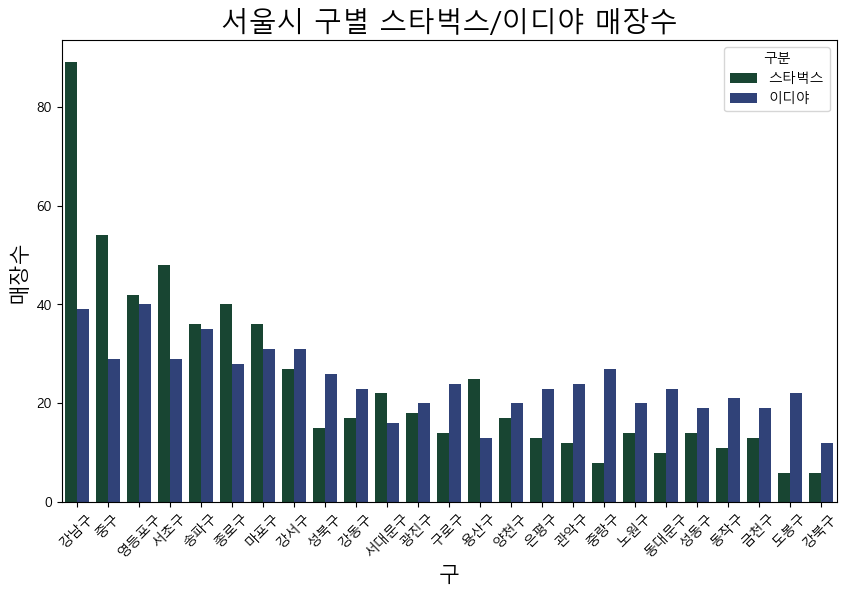

In [55]:
draw_countplot()

* 스타벅스와 이디야는 모두 서울 매장이 600여개로 비슷한 수준이나 구별 매장 분포는 큰 차이를 보임
* 스타벅스는 강남구, 중구, 서초구 등 매장 수 상위 5~7개구에 매장 대부분이 몰렸있음
* 이디야도 강남구, 영등포구 등이 다른 구에 비해 많은 매장이 위치하고 있지만, 스타벅스에 비해 구별로 고른 분포를 보이고 있음

In [56]:
# 구별 인구와 관계가 있는지 확인
# '서울시 열린데이터 광장'(https://data.seoul.go.kr/dataList/419/S/2/datasetView.do)에서 수집한 2022 서울시 구별 주민등록인구
population = pd.read_csv('./data/주민등록인구_20231109120918.csv', header=2)
population

,동별(1),동별(2),소계,남자,여자,소계.1,남자.1,여자.1,소계.2,남자.2,여자.2,소계.3
0,합계,종로구,152211,72980,79231,141379,68395,72984,10832,4585,6247,1.95
1,합계,중구,130785,63377,67408,120437,58563,61874,10348,4814,5534,1.91
2,합계,용산구,233284,113012,120272,218650,105087,113563,14634,7925,6709,1.99
3,합계,성동구,288234,139691,148543,281000,136633,144367,7234,3058,4176,2.11
4,합계,광진구,351252,168197,183055,337416,162541,174875,13836,5656,8180,1.99
5,합계,동대문구,353601,171903,181698,336644,165755,170889,16957,6148,10809,1.98
6,합계,중랑구,390140,191422,198718,385318,189537,195781,4822,1885,2937,2.06
7,합계,성북구,441984,211246,230738,430397,206961,223436,11587,4285,7302,2.18
8,합계,강북구,297702,144037,153665,293660,142567,151093,4042,1470,2572,2.03
9,합계,도봉구,313989,152175,161814,311694,151398,160296,2295,777,1518,2.25


In [57]:
population.rename(columns={'동별(2)': '구', '소계': '인구', '소계.1': '한국인', '소계.2': '외국인'}, inplace=True)
population = population[['구', '인구', '한국인', '외국인']]
population

,구,인구,한국인,외국인
0,종로구,152211,141379,10832
1,중구,130785,120437,10348
2,용산구,233284,218650,14634
3,성동구,288234,281000,7234
4,광진구,351252,337416,13836
5,동대문구,353601,336644,16957
6,중랑구,390140,385318,4822
7,성북구,441984,430397,11587
8,강북구,297702,293660,4042
9,도봉구,313989,311694,2295


In [58]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   구       25 non-null     object
 1   인구      25 non-null     int64 
 2   한국인     25 non-null     int64 
 3   외국인     25 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 928.0+ bytes


In [59]:
population.to_csv('./data/population_of_seoul_by_gu.csv', index=0, sep=',', encoding='utf-8')

In [60]:
population = pd.read_csv('./data/population_of_seoul_by_gu.csv', encoding='utf-8')
population

,구,인구,한국인,외국인
0,종로구,152211,141379,10832
1,중구,130785,120437,10348
2,용산구,233284,218650,14634
3,성동구,288234,281000,7234
4,광진구,351252,337416,13836
5,동대문구,353601,336644,16957
6,중랑구,390140,385318,4822
7,성북구,441984,430397,11587
8,강북구,297702,293660,4042
9,도봉구,313989,311694,2295


In [61]:
population.sort_values(by='인구', ascending=False)

,구,인구,한국인,외국인
23,송파구,664514,658801,5713
15,강서구,574638,569166,5472
22,강남구,534103,529102,5001
10,노원구,508014,503734,4280
20,관악구,501226,486752,14474
11,은평구,470602,466746,3856
24,강동구,464037,460067,3970
14,양천구,444010,440881,3129
7,성북구,441984,430397,11587
16,구로구,418418,395315,23103


In [62]:
combined_df

,store,구,addr,lat,lng,구분
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스
...,...,...,...,...,...,...
1216,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야
1217,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야
1218,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야
1219,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야


In [63]:
def drawGraph_with_pop():
    plt.figure(figsize=(14, 8))
    ax1 = sns.countplot(data=combined_df, x='구', hue='구분', 
                  order=combined_df['구'].value_counts().index, 
                  palette={'스타벅스': '#104C33', '이디야':'#243C84'})
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()

    # combined_df의 x축과 인구 데이터의 '구' 순서를 일치시킵니다.
    ordered_population = population.set_index('구').loc[combined_df['구'].value_counts().index].reset_index()

    # 재정렬된 인구 데이터를 사용해 선 그래프를 그립니다.
    sns.lineplot(data=ordered_population, x='구', y='인구', sort=False, ax=ax2, color='black', marker="s")

    plt.xlabel('구', size=15)
    ax1.set_ylabel('매장수', size=15)
    ax2.set_ylabel('인구수', size=15)
    plt.title('서울시 구별 스타벅스/이디야 매장수와 구별 인구', size=20)
    ax1.legend(title='구분', loc='upper left')
    ax2.legend(['인구'], loc='upper right')
    plt.grid(True)
    plt.show()

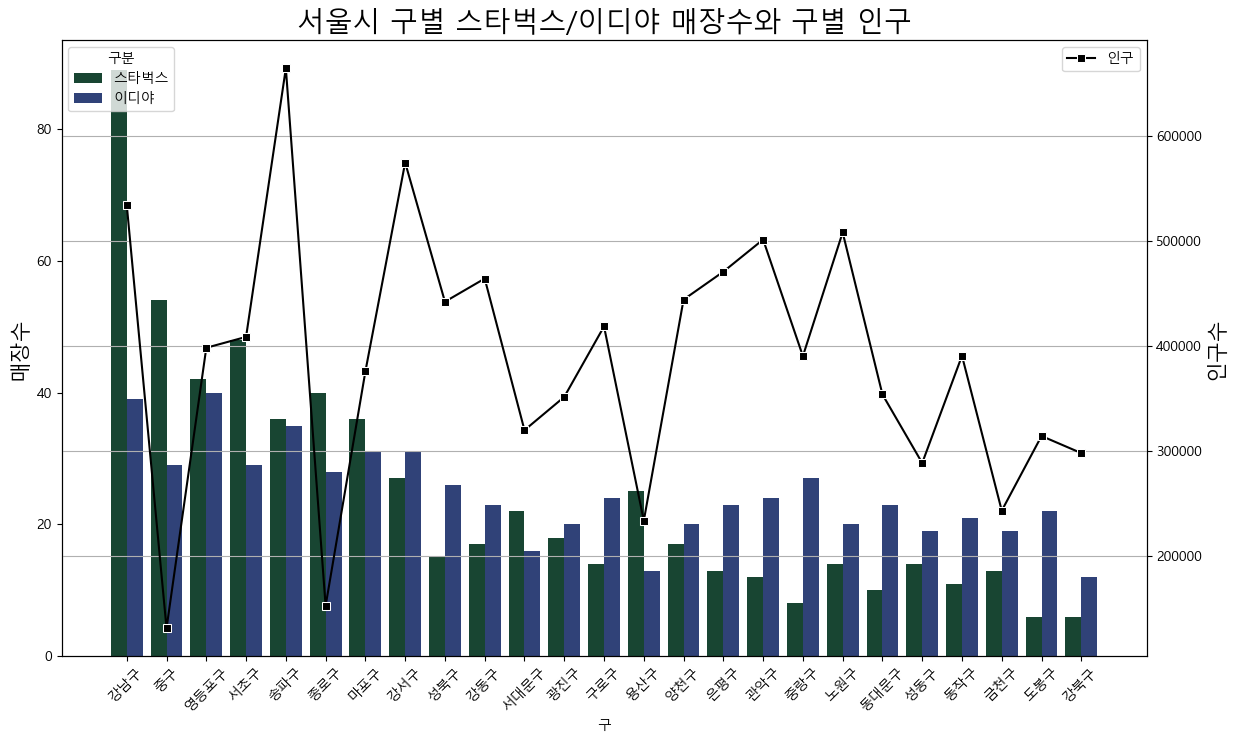

In [64]:
drawGraph_with_pop()

* 그래프로는 구별 인구와 매장수간에 뚜렷한 관계가 관찰되지 않음
* 스타벅스의 매장수가 많은 강남구, 중구, 영등포구, 서초구 등은 상업지역이 위치해 있고 유동인구 많은 지역임
* 개인점주가 주를 이루는 이디야의 경우 임대료가 높은 지역에 입점하는데는 제한이 많을 것으로 예상됨
* 위와 같은 추측을 확인하기 위해선 유동인구, 임대료 등의 데이터가 필요함

### 3-2-2. folium을 이용한 지도 시각화

In [66]:
def draw_folium_Graph():
    geo_path = './data/02. skorea_municipalities_geo_simple.json'
    geo_str = json.load(open(geo_path, encoding='utf-8'))

    seoul = folium.Map(
        location=(37.5502, 126.982),
        zoom_start=12,
        tiles='cartodbpositron'
        )
    
    pop = population.set_index('구')

    folium.Choropleth(
        geo_data=geo_str,
        data=pop['인구'],
        columns=[pop.index, pop['인구']],
        key_on='feature.id',
        fill_color='RdPu',
        fill_opacity=0.4,
        line_opacity=0.4,
        legend_name='구별 인구'
    ).add_to(seoul)
    
    for _, row in combined_df.iterrows():
        folium.Marker(
            location=(row['lat'], row['lng']),
            popup= row['store'],
            tooltip= row['구분'], 
            icon=folium.Icon(
                icon_color= '#104C33' if row['구분'] == '스타벅스' else '#243C84',
                icon='star' if row['구분'] == '스타벅스' else 'mug-saucer',
                prefix='fa'
            )
        ).add_to(seoul)

    return seoul

In [69]:
draw_folium_Graph()

- 스타벅스는 초록색 별, 이디야는 파란색 컵 모양의 아이콘으로 서울시 지도에 시각화
- 구별 인구가 많을 수록 진한 색으로 시각화였다. 

- 스타벅스와 이디야 각각 600 이상의 매장이 존재하므로 1200개 이상의 마커 
- 지도를 확대해 구별로 살펴보면 스타벅스 매장 인근에 반드시 이디야 매장이 있지는 않음
- 앞서 구별 매장 수에 대한 시각화에서 살펴 보았듯, 강남구와 중구에 매우 많은 마커가 밀집해 있음을 눈으로 확인할 수 있음

## 3-3. 스타벅스와 이디야 매장간 거리 계산

In [71]:
df_starbucks

,store,구,addr,lat,lng,구분
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스
...,...,...,...,...,...,...
602,사가정역,중랑구,서울특별시 중랑구 면목로 310,37.579594,127.087966,스타벅스
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,스타벅스
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,스타벅스
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,스타벅스


In [72]:
df_ediya

,store,구,addr,lat,lng,구분
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702,이디야
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160,이디야
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106,이디야
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429,이디야
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429,이디야
...,...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야


In [75]:
# haversine 모듈을 사용해 두 지점간 거리를 계산
# 테스트

ediya1 = (37.509943, 127.035702) # 이디야 강남YMCA점
star1 = (37.501087, 127.043069) # 스타벅스 역삼아레나빌딩
haversine(ediya1, star1) # 킬로미터 단위로 계산된 거리를 반환

1.17983920649527

- 구글 지도를 통해 두 지점의 거리를 계산한 결과는 1.2km
- 구글 지도와 오차는 30m

In [120]:
def get_distance(first_df, second_df):
    first_location = []
    for _, row in first_df.iterrows():
        first_location.append((row['lat'], row['lng']))

    second_location = []
    for _, row in second_df.iterrows():
        second_location.append((row['lat'], row['lng']))

    first_dist = []
    second_dist = []

    # 가장 가까운 이디야 매장과의 거리를 구함(m 단위)
    for first in tqdm(first_location):
        min_first = np.inf
        for second in second_location:
            distance = haversine(first, second, unit=Unit.METERS) 
            if distance < min_first:
                min_first = distance
        first_dist.append(int(min_first))
    
    # 가장 가까운 스타벅스 매장과의 거리를 구함(m 단위)
    for second in tqdm(second_location):
        min_second = np.inf
        for first in first_location:
            distance = haversine(second, first, unit=Unit.METERS)
            if distance < min_second:
                min_second = distance
        second_dist.append(int(min_second))
        
    result_first = first_df.copy()
    result_second = second_df.copy()
    result_first['가까운 상대 매장(m)'] = first_dist
    result_second['가까운 상대 매장(m)'] = second_dist

    return result_first, result_second

In [121]:
tmp_star, tmp_edy = get_distance(df_starbucks, df_ediya)

  0%|          | 0/607 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

In [122]:
tmp_star

,store,구,addr,lat,lng,구분,가까운 상대 매장(m)
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스,86
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스,207
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스,121
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스,415
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스,643
...,...,...,...,...,...,...,...
602,사가정역,중랑구,서울특별시 중랑구 면목로 310,37.579594,127.087966,스타벅스,603
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,스타벅스,284
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,스타벅스,237
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,스타벅스,98


In [134]:
tmp_star[tmp_star['가까운 상대 매장(m)'] < 500]

,store,구,addr,lat,lng,구분,가까운 상대 매장(m)
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스,86
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스,207
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스,121
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스,415
6,압구정윤성빌딩,강남구,서울특별시 강남구 논현로 834 (신사동),37.522793,127.028601,스타벅스,384
...,...,...,...,...,...,...,...
601,중랑구청,중랑구,서울특별시 중랑구 신내로 72,37.605389,127.095756,스타벅스,263
603,상봉역,중랑구,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,스타벅스,284
604,묵동,중랑구,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,스타벅스,237
605,양원역,중랑구,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,스타벅스,98


- 스타벅스 전체 607개 매장 중 493개가 500m 이내 이디야 매장이 존재함

In [123]:
tmp_star.describe()

,lat,lng,가까운 상대 매장(m)
count,607.000000,607.000000,607.000000
mean,37.539477,126.991063,318.614498
std,0.041383,0.076504,275.155347
min,37.447323,126.806080,3.000000
25%,37.506984,126.931466,137.000000
50%,37.537817,126.991782,253.000000
75%,37.565345,127.044916,414.500000
max,37.665312,127.174104,3317.000000


- 가까운 이디야 매장까지의 평균거리 : 318m

In [124]:
tmp_edy

,store,구,addr,lat,lng,구분,가까운 상대 매장(m)
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702,이디야,250
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160,이디야,95
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106,이디야,239
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429,이디야,291
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429,이디야,291
...,...,...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야,486
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야,237
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야,31
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야,277


In [135]:
tmp_edy[tmp_edy['가까운 상대 매장(m)'] < 500]

,store,구,addr,lat,lng,구분,가까운 상대 매장(m)
0,강남YMCA점,강남구,서울 강남구 논현동 230-2,37.509943,127.035702,이디야,250
1,강남구청역아이티웨딩점,강남구,"서울 강남구 학동로 338 (논현동, 강남파라곤)",37.516542,127.040160,이디야,95
2,강남논현학동점,강남구,서울 강남구 논현로131길 28 (논현동),37.514080,127.028106,이디야,239
3,강남대치점,강남구,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",37.501339,127.052429,이디야,291
4,강남도산점,강남구,서울 강남구 도산대로37길 20 (신사동),37.501339,127.052429,이디야,291
...,...,...,...,...,...,...,...
609,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야,486
610,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야,237
611,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야,31
612,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야,277


* 이디야 전체 614개 매장 중 437개가 500m 이내 스타벅스 매장이 존재함

In [125]:
tmp_edy.describe()

,lat,lng,가까운 상대 매장(m)
count,614.000000,614.000000,614.000000
mean,37.547512,126.990863,401.363192
std,0.051171,0.086173,380.282273
min,37.434112,126.806994,3.000000
25%,37.505157,126.916598,131.000000
50%,37.547035,127.005689,283.500000
75%,37.579345,127.057496,585.500000
max,37.687538,127.175934,2471.000000


- 가까운 이디야 매장까지의 평균거리 : 401m
- 스타벅스에 비해 상대 브랜드까지의 평균거리가 83m 더 멈

In [126]:
combined_distance = pd.concat([tmp_star, tmp_edy])
combined_distance.reset_index(drop=True, inplace=True)
combined_distance

,store,구,addr,lat,lng,구분,가까운 상대 매장(m)
0,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069,스타벅스,86
1,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223,스타벅스,207
2,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606,스타벅스,121
3,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495,스타벅스,415
4,대치재경빌딩R,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583,스타벅스,643
...,...,...,...,...,...,...,...
1216,중랑교차로점,중랑구,서울 중랑구 동일로 683 (면목동),37.591448,127.079882,이디야,486
1217,중랑묵동점,중랑구,"서울 중랑구 동일로 932 (묵동, 묵동자이아파트)",37.613353,127.077536,이디야,237
1218,중랑역점,중랑구,서울 중랑구 망우로 198 (상봉동),37.593285,127.074889,이디야,31
1219,중화동점,중랑구,서울 중랑구 동일로129길 1 (중화동),37.599384,127.079543,이디야,277


In [131]:
combined_distance.describe()

,lat,lng,가까운 상대 매장(m)
count,1221.000000,1221.000000,1221.000000
mean,37.543517,126.990962,360.226044
std,0.046717,0.081477,334.638758
min,37.434112,126.806080,3.000000
25%,37.505760,126.922130,133.000000
50%,37.541456,126.999650,261.000000
75%,37.570214,127.051536,478.000000
max,37.687538,127.175934,3317.000000


In [132]:
def draw_distance_by_boxplot():
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=combined_distance, x='구', y='가까운 상대 매장(m)', 
                hue='구분', palette={'스타벅스': '#104C33', '이디야':'#243C84'})
    plt.xticks(rotation=45)
    plt.title('가장 가까운 상대 브랜드 매장까지의 거리(스타벅스/이디야)', size=20)
    plt.grid(True)
    plt.show()

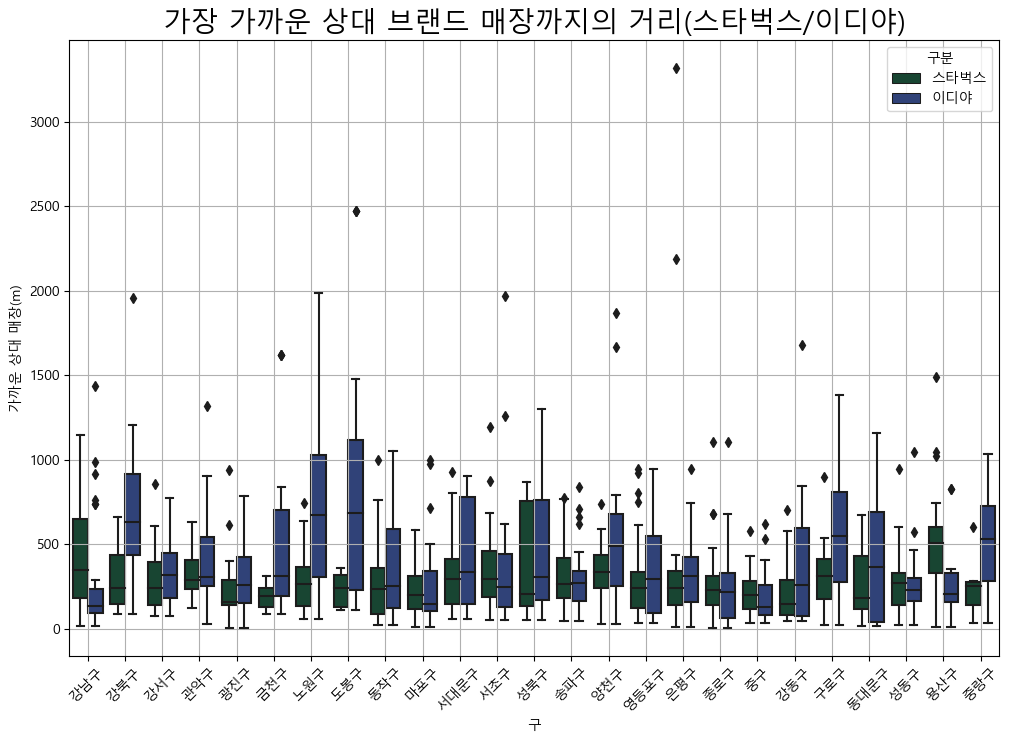

In [133]:
draw_distance_by_boxplot()

- 이디야가 스타벅스에 비해 상대 브랜드 매장까지의 거리 분포가 더 넗은 편임
- 스타벅스 그래프를 보면, 전체 25개구 중 22개구에서 가장 가까운 이디야 매장이 500m 이내 위치함
- 이디야는 대략 절반 정도의 구에서 가장 가까운 스타벅스 매장까지의 거리가 500m 이상인 경우가 존재함

=> 
- '이디야가 스타벅스 매장이 위치하는 곳에 매장을 위치시키는 것이 아니냐는 의심'은 스타벅스 입장에선 근거가 있는 걸로 보임
- 이디야 입장에선 구별 매장 분포도 스타벅스와는 다른 양상을 보이고, 가까운 스타벅스 매장과의 거리가 500m 이상인 매장도 다수 존재함
- 이디야 회장이 위와 같은 의심에 대해 부인한 것도 적절한 근거가 있다고 판단됨

- 스타벅스와 이디야 모두 서울에 위치한 600여개 매장 중 400개 이상의 매장이 상대 브랜드 매장까지의 거리가 400m 내
- 하지만, 두 브랜드가 같은 업종인 점을 생각하면 입점을 위해 고려할 요소들이 유사할 수 있기 때문에 거리만으로 판단이 어려움

- 구별 매장 분포에서 상당히 다른 분포를 보이는 것을 생각하면, 두 브랜드가 고려하는 입점 요소에 차이가 있다고 생각할 수 있음

- 결론 : 이디야는 스타벅스 매장 주변에 매장을 위치시킨다고 볼 수 없음